### Lab 2: Hyponyms and Hypernyms

In [29]:
import pandas as pd
!pip install wikipedia
import wikipedia
import os
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
from IPython.display import display
import json
num_cores = multiprocessing.cpu_count()
print(num_cores)
wikipedia.set_lang("ru")
# DATA_PATH_LIST = ['D:','src2','taxonomy-enrichment','data','training_data']
DATA_PATH_LIST = ['.']
EMBEDDING_MODEL_FILENAME = "wiki_node2vec.bin"
DATA_PATH="/".join(DATA_PATH_LIST+["training_nouns.tsv"])
df = pd.read_csv(DATA_PATH,sep='\t')
%matplotlib inline

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=e7c3e5525df3c45ce77d466fbac98289d7a599c4eecff96a8d1fa06d949585ec
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia
2


In [0]:
def prestr(x):
    return str(x).replace('\"','').replace("'",'"')

In [0]:
class DefDict(defaultdict):
    def __missing__(self, key):
        self[key] = key
        return key
    
idx2syns = DefDict(lambda x:x)
for val in df.values:
    idx2syns[val[0]]=val[1]
    try:
        pidxs = json.loads(prestr(val[2]))
        concp = [el.split(",")[0] for el in json.loads(prestr(val[3]))]
        idx2syns.update(dict(zip(pidxs,concp)))
    except:
        print(prestr(val[2]))
        print(prestr(val[3]))

### Interactive visualization of hyponyms and hypernyms

Button(description='Draw', style=ButtonStyle())

Text(value='МАТЬ', description='String:', placeholder='Query')

graphdraw МАТЬ
['ИГУМЕН МОНАСТЫРЯ', ' ИГУМЕНЬЯ МОНАСТЫРЯ', ' МАТЬ-ИГУМЕНЬЯ', ' ОТЕЦ-ИГУМЕН', ' ИГУМЕНЬЯ', ' ИГУМЕН']
['МОЛОЧНАЯ МАТЬ', ' КОРМИЛИЦА']
['СПОСОБНОСТЬ ПОНИМАТЬ ЗНАЧЕНИЕ СВОИХ ДЕЙСТВИЙ', ' ВМЕНЯЕМОСТЬ']
['СПОСОБНОСТЬ ПОНИМАТЬ ЗНАЧЕНИЕ СВОИХ ДЕЙСТВИЙ', ' ВМЕНЯЕМОСТЬ']
['СУРМАМА', ' СУРРОГАТНАЯ МАМА', ' СУРРОГАТНАЯ МАТЬ', ' СУРРОГАТНОЕ МАТЕРИНСТВО']
['СВЕКРОВЬ', ' МАТЬ МУЖА']
['МАТЬ ЖЕНЫ', ' ТЕЩА']


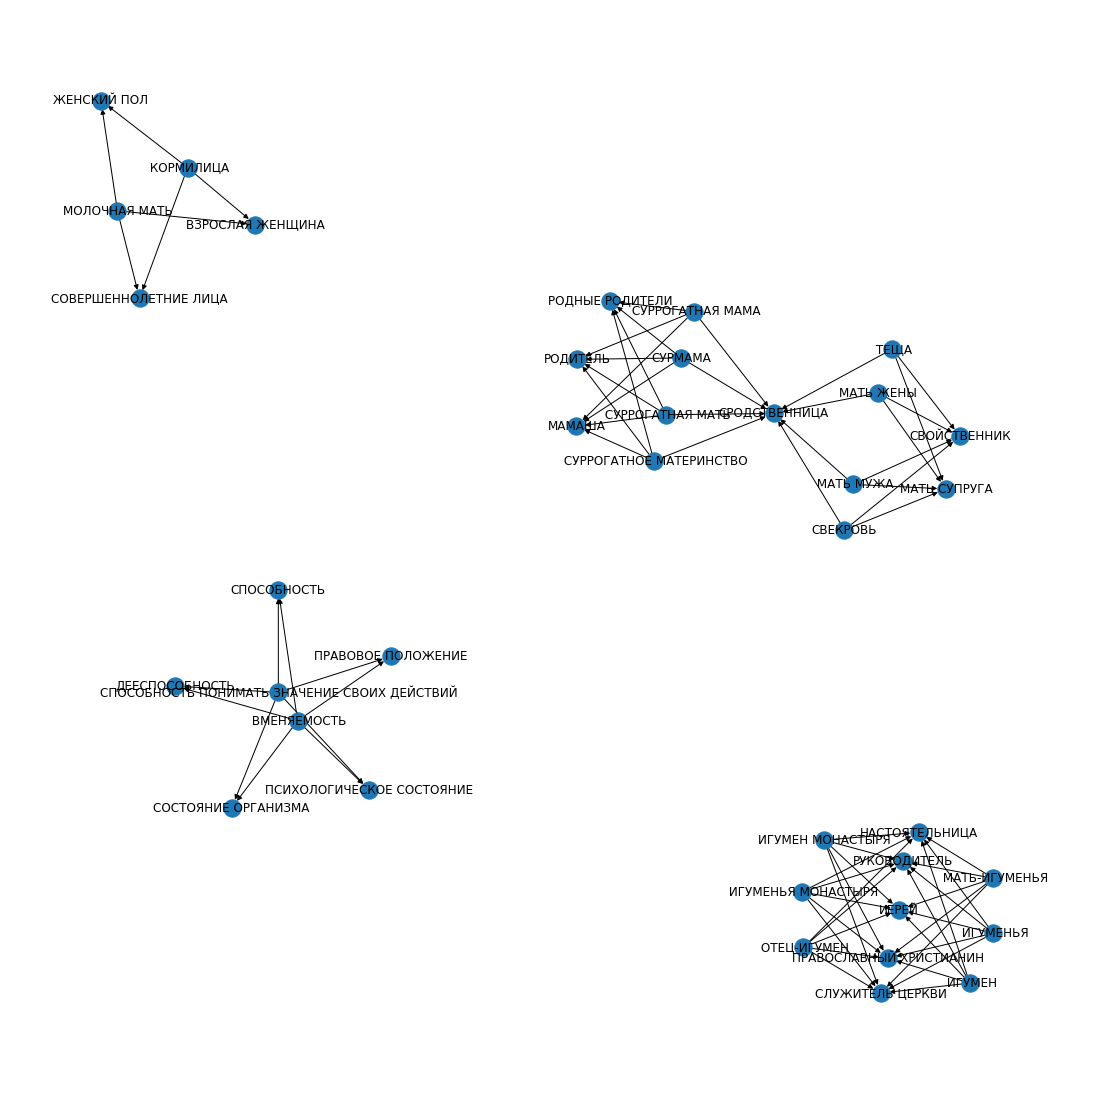

In [0]:
button = widgets.Button(description="Draw")
query = widgets.Text(
    value='МАТЬ',
    placeholder='Query',
    description='String:',
    disabled=False
)
display(button,query)




def creategraph(df):
    res = []
    for row in df.values:
        cohyps = row[1].split(",")
        for idx,cohyp in enumerate(cohyps):
            for parent in json.loads(prestr(row[2])):
                res.append((row[0]+'-'+str(idx),parent))
    return res

def graphdraw(b):
    print("graphdraw",query.value)
    subset = df[df['TEXT'].str.contains(query.value.upper())]
    g = nx.DiGraph()
    for el in subset.values:
        cohyps = el[1].split(",")
        print(cohyps)
        syns = idx2syns[el[0]]
        for child in cohyps:
            for parent in json.loads(prestr(el[2])):
                ed = g.add_edge(child,idx2syns[parent],label="is a")
            
    plt.figure(figsize=(15,15))
    pos = nx.nx_agraph.graphviz_layout(g)
    nx.draw(g,with_labels=True,pos=pos)
#     edge_labels=nx.draw_networkx_edge_labels(g,pos=pos)
    plt.show()
button.on_click(graphdraw)

### Pattern extractor

Yargy — библиотека для извлечения структурированной информации из текстов на русском языке. Правила описываются контекстно-свободными грамматиками и словарями ключевых слов. Банк готовых правил для имён, дат, адресов и других сущностей доступен в репозитории Natasha.
* https://yargy.readthedocs.io/ru/latest/
* http://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
* https://github.com/natasha/natasha

### Токенизатор

In [17]:
!pip install natasha
from yargy.tokenizer import MorphTokenizer


tokenizer = MorphTokenizer()
text = '''Ростов-на-Дону
Длительностью 18ч. 10мин.
Яндекс.Такси
π ≈ 3.1415
1 500 000$
http://vk.com
'''
for line in text.splitlines():
    print([_.value for _ in tokenizer(line)])

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 7.1MB 8.8MB/s 
['Ростов', '-', 'на', '-', 'Дону']
['Длительностью', '18', 'ч', '.', '10', 'мин', '.']
['Яндекс', '.', 'Такси']
['π', '≈', '3', '.', '1415']
['1', '500', '000', '$']
['http', ':', '/', '/', 'vk', '.', 'com']


# Газеттир
Газеттир нужен для удобной работы с последовательностью слов. Например, можно написать:

In [0]:
from yargy import or_, rule
from yargy.predicates import normalized

RULE = or_(
    rule(normalized('dvd'), '-', normalized('диск')),
    rule(normalized('видео'), normalized('файл'))
)

In [19]:
from yargy import Parser
from yargy.pipelines import morph_pipeline


RULE = morph_pipeline([
    'dvd-диск',
    'видео файл',
    'видеофильм',
    'газета',
    'электронный дневник',
    'эссе',
])

parser = Parser(RULE)
text = 'Видео файл на dvd-диске'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['Видео', 'файл']
['dvd', '-', 'диске']


In [20]:
from yargy import Parser, rule, and_
from yargy.predicates import gram, is_capitalized, dictionary


GEO = rule(
    and_(
        gram('ADJF'),  # так помечается прилагательное, остальные пометки описаны в
                       # http://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
        is_capitalized()
    ),
    gram('ADJF').optional().repeatable(),
    dictionary({
        'федерация',
        'республика'
    })
)


parser = Parser(GEO)
text = '''
В Чеченской республике на день рождения ...
Донецкая народная республика провозгласила ...
Башня Федерация — одна из самых высоких ...
'''
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['Чеченской', 'республике']
['Донецкая', 'народная', 'республика']


### Предикаты

Предикат — функция, которая принимает на вход токен и возвращает True или False. В Yargy встроено много готовых предикатов. Полный список есть в справочнике. Предикаты комбинируются с помощью and_, or_ и not_.

In [21]:
from yargy import and_, not_
from yargy.tokenizer import MorphTokenizer
from yargy.predicates import is_capitalized, eq


tokenizer = MorphTokenizer()
token = next(tokenizer('Стали'))

predicate = is_capitalized()
print(predicate(token))

predicate = and_(
    is_capitalized(),
    not_(eq('марки'))
)
print(predicate(token))

True
True


### Грамматики
В Yargy используется специальный DSL для описания грамматик. Любую контекстно-свободную грамматику можно описать с помощью конструкций Питона. Например, есть примитивная грамматика для размеров одежды:

KEY -> р. | размер

VALUE -> S | M | L

SIZE -> KEY VALUE



In [22]:
from yargy import rule, or_


KEY = or_(
    rule('р', '.'),
    rule('размер')
).named('KEY')
VALUE = or_(
    rule('S'),
    rule('M'),
    rule('L'),
    rule('XS'),
).named('VALUE')
SIZE = rule(
    KEY,
    VALUE
).named('SIZE')
SIZE.normalized.as_bnf

SIZE -> KEY VALUE
KEY -> 'р' '.' | 'размер'
VALUE -> 'S' | 'M' | 'L' | 'XS'


In [23]:
parser = Parser(
    SIZE
)
text = 'размер M; размер A; размер XS;'
for match in parser.findall(text):
    print([_.value for _ in match.tokens])

['размер', 'M']
['размер', 'XS']


In [0]:
from yargy import Parser, rule, and_, or_, not_
from yargy.interpretation import fact, attribute
from yargy.predicates import gram, is_capitalized, dictionary, eq
import re
import pandas as pd
from tqdm import tqdm_notebook
from gensim import utils

In [0]:

START = rule(
    or_(
        rule(gram('ADJF')),
        rule(gram('NOUN'))
    ).optional(),
    gram('NOUN')
)

START_S = or_(
    eq('такой'),
    eq('такие'),
)

KAK = eq('как')
INCLUDING = or_(
    or_(
        eq('в'),
        eq('том'),
        eq('числе'),
    ),
    eq('включающий'),
    or_(
        eq('включающий'),
        eq('в'),
        eq('себя'),
    ),
    or_(
        eq('включающие'),
        eq('в'),
        eq('себя'),
    ),
    eq('включающие'),
    eq('особенно'),

)

MID_S = or_(
    rule(
        or_(
            eq('такой'),
            eq('такие'),
        ),
        eq('как')
    )
)
ATAKJE = rule(
    eq(','),
    eq('а'),
    eq('также')
)

MID = or_(
    rule(
        eq('это')
    ),
    rule(
        eq('—')
    ),
    rule(
        eq('—'),
        eq('это')
    ),
    rule(
        eq('—'),
        not_(eq('км'))
    ),
    rule(
        or_(
            eq('и'),
            eq('или'),
        ),
        eq('другие')
    )
)

END = or_(
    rule(
        gram('NOUN'),
        gram('NOUN')
    ),
    rule(
        gram('ADJF').repeatable(),
        gram('NOUN')
    ),
    rule(
        gram('ADJF'),
        gram('ADJF').repeatable(),
        gram('NOUN')
    ),
    rule(
        gram('NOUN').repeatable(),
        gram('ADJF'),
        gram('NOUN').repeatable()
    ),
    rule(
        gram('NOUN').repeatable()
    )
)

Item = fact(
    'Item',
    [attribute('titles').repeatable()]
)


IGNORE = rule(
    '(',
    not_(eq(')')).repeatable(),
    ')'
)

ITEM = rule(
    IGNORE.interpretation(
        Item.titles
    ),
    eq(',').optional() 
).repeatable().interpretation(
    Item
)

In [0]:
def get_hyperonyms(main_word):
    HYPONYM = eq(utils.deaccent(main_word))
    RULE = or_(
        rule(HYPONYM, ATAKJE, START, MID, END),
        rule(HYPONYM, MID, END),
        rule(START_S, END, KAK, HYPONYM),
        rule(END, INCLUDING, HYPONYM)
    )
    parser = Parser(RULE) 
    text = utils.deaccent(wikipedia.summary(main_word))
    print(text)
    text = re.sub(r'\(.+?\)', '', text)
    text = text.lower().replace('* сергии радонежскии* ', '')
    for idx, match in enumerate(parser.findall(text.lower())):
        k = [_.value for _ in match.tokens]
        print(k)

In [30]:
get_hyperonyms("банан")

Банан — название съедобных плодов культивируемых растении рода Банан (Musa); обычно под таковыми понимают Musa acuminata и Musa × paradisiaca, а также Musa balbisiana, Musa fehi, Musa troglodytarum и ряд других. Также бананами могут называть плоды Ensete ventricosum (строго говоря, являющегося представителем другого рода семеиства Банановые). С ботаническои точки зрения банан является ягодои, многосеменнои и толстокожеи. У культурных форм часто отсутствуют семена, ненужные при вегетативном размножении. Плоды имеют длину 6—30 см и диаметр 2—5 см. Соплодия могут состоять из 300 плодов и иметь массу до 50—60 кг.
Бананы — одна из древнеиших пищевых культур, а для тропических стран важнеишее пищевое растение и главная статья экспорта. Спелые бананы широко употребляются в пищу по всему миру, их используют при приготовлении большого количества блюд. Помимо употребления в свежем виде, в кухне некоторых народов бананы могут зажариваться, или вариться как в очищенном, так и в неочищенном виде. И

#### Task 1 (deadline 19.02.2020 24:00)
* Find your name on the spreadsheet https://docs.google.com/spreadsheets/d/1RR2I6toCkebbGU1UK83HS70Ru_l0_o-nnZIHyiFB0No/edit?usp=sharing. In opposite of your name there are 24 words of hyponyms, you have to insert five corresponding hypernyms next to them. Examples of hyponyms and hyperonyms relationship you can find above in the current Jupiter notebook.
* Find for each pair of hyponyms and hypernyms a corresponding snippet of a text with their mentions. The source of the text can be any free resources, e.g., Wikipedia, Google, Yandex, others. You should save the snippets and their URLs within the lab2 folder in your NLP git-repo with .csv file-extension in a single file.

#### Task 2 (deadline 26.02.2020 24:00)
* It would be best if you created a pandas DataFrame of the texts from the previous task. And apply to the DataFrame the function 'get_hyperonyms,' which must return the list of the corresponding hypernyms from the text automatically. If there are errors or misses, you should fix them in the code for your case of the 24 words. Nevertheless, it is strictly prohibited to use hard coding. Save your notebook with parser code within the lab2 folder in your NLP git-repo.

In [31]:
import pandas as pd
homework_data = pd.read_excel('hyperonyms.xlsx', sheet_name='Лист1')

homework_data.head()

,words
0,ЭСХАТОЛОГИЯ
1,ЭТАЖЕРКА
2,ЭТИЛЕН
3,ЭТИОЛОГИЯ
4,ЭТРУСК


In [32]:
for word in list(homework_data['words']):
    print('Гиперонимы для слова: ', word)
    print('\n')
    get_hyperonyms(word)
    print('\n\n')

Гиперонимы для слова:  ЭСХАТОЛОГИЯ


Эсхатология (греч. εσχατολογια, от др.-греч. εσχατον — «конечныи», «последнии» + λογος — «слово», «знание») — система религиозных взглядов и представлении о конце истории, искуплении и загробнои жизни, о судьбе Вселеннои и ее переходе в качественно новое состояние. Также отрасль богословия, изучающая эту систему взглядов и представлении в рамках тои или инои религиознои доктрины. 
В религии различаются индивидуальная эсхатология (учение о судьбе личности) и всемирная эсхатология (учение о цели космоса и истории, а также их конце).
Эсхатологические представления своиственны многим религиозно-мифологическим системам в истории человечества.



Гиперонимы для слова:  ЭТАЖЕРКА


Этажерка (от фр. Etagere — полка) — напольное или навесное изделие мебели, разновидность стеллажа, полки которого открыты со всех сторон и опираются на вертикальные стоики. У этажерок отсутствуют фасад и стенки, но сама этажерка в напольном варианте может иметь нижнюю закрытую ту